# Training Set Markov Chain

* [Course Reviews on Coursera](https://www.kaggle.com/datasets/imuhammad/course-reviews-on-coursera)
* [Coursera Courses 2021](https://www.kaggle.com/datasets/khusheekapoor/coursera-courses-dataset-2021)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from coursemate.dataset import Dataset

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

In [4]:
%load_ext autoreload
%autoreload 2

## Dataset class

In [5]:
dataset = Dataset('../data/Coursera_courses.csv', '../data/Coursera.csv', '../data/Coursera_reviews.csv')
dataset.set_interaction_counts(3, 50)
dataset.show_dataset_details()

Loading Coursera courses...
Loading Coursera reviews...
Segmenting out students with less than 3 or more than 50 reviews...
30719 students, 468 courses, 174219 reviews
Sparsity: 1.21%
Duplicates: 4.54%


## Getting the train-test split as a list of data points

In [6]:
dataset.set_train_test_split_by_user()
train_X, test_X, train_y, test_y = dataset.get_train_test_sequence_predictions()

Setting the train-test split by user...
Computing the training and test list of sequences...


131100it [00:06, 21781.77it/s]
43119it [00:02, 21477.97it/s]


In [7]:
for x, y in zip(train_X[:10], train_y[:10]):
    print(f"{x[0]} : {x[1]} => {y}")

By  B R s  : ('information-security-data',) => aws-fundamentals-going-cloud-native
By  B R s  : ('information-security-data', 'aws-fundamentals-going-cloud-native') => python-basics
By  B R s  : ('information-security-data', 'aws-fundamentals-going-cloud-native', 'python-basics') => introduction-cybersecurity-cyber-attacks
By  B S K : ('python-data',) => neural-networks-deep-learning
By  B S K : ('python-data', 'neural-networks-deep-learning') => deep-neural-network
By  B S K : ('python-data', 'neural-networks-deep-learning', 'deep-neural-network') => machine-learning-projects
By  B S K : ('python-data', 'neural-networks-deep-learning', 'deep-neural-network', 'machine-learning-projects') => introduction-tensorflow
By  B S K : ('python-data', 'neural-networks-deep-learning', 'deep-neural-network', 'machine-learning-projects', 'introduction-tensorflow') => convolutional-neural-networks-tensorflow
By  B S K : ('python-data', 'neural-networks-deep-learning', 'deep-neural-network', 'machine

In [8]:
for x, y in zip(test_X[:10], test_y[:10]):
    print(f"{x[0]} : {x[1]} => {y}")

By  A O : ('python-network-data',) => python-databases
By  A O : ('python-network-data', 'python-databases') => ai-for-everyone
By  J  : ('learning-how-to-learn',) => physiology
By  J  : ('learning-how-to-learn', 'physiology') => technical-support-fundamentals
By  K B : ('horse-care',) => python
By  K B : ('horse-care', 'python') => fundamentals-of-graphic-design
By  K B  : ('excel-intermediate-1',) => python
By  K B  : ('excel-intermediate-1', 'python') => os-power-user
By  K R  : ('neural-networks-deep-learning',) => deep-neural-network
By  K R  : ('neural-networks-deep-learning', 'deep-neural-network') => machine-learning-projects


## Constructing an adjacency matrix

In [9]:
adj_matrix = np.zeros((468, 468))
curr_user = ''
curr_course = ''

for (user, prev_courses), next_course in tqdm(zip(train_X, train_y)):
    if curr_user != user:
        # new user
        curr_user = user
        if len(prev_courses) != 1:
            raise ValueError('User not in fact new')
        curr_course = next(iter(prev_courses))
        # print(f"New pair: {str(prev_courses)} -> {next_course}")
        
    # if curr_course == next_course:
    #     raise ValueError(f"User {user} is taking {curr_course} twice?")
    curr_ndx = dataset.course_set.index.get_loc(curr_course)
    next_ndx = dataset.course_set.index.get_loc(next_course)
    adj_matrix[curr_ndx, next_ndx] += 1
    curr_course = next_course

108061it [00:00, 557925.33it/s]


In [10]:
adj_matrix

array([[210.,  62.,  20., ...,   0.,   0.,   1.],
       [ 59., 139.,  15., ...,   1.,   0.,   2.],
       [ 12.,  20.,   3., ...,   0.,   0.,   0.],
       ...,
       [  2.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  3.,   2.,   0., ...,   0.,   0.,   0.]])

In [11]:
diag_ctr = np.sum([adj_matrix[i, i] for i in range(adj_matrix.shape[0])])
print(f"Total self-transitions: {diag_ctr}")

for i in range(adj_matrix.shape[0]):
    adj_matrix[i, i] = 0

Total self-transitions: 1363.0


In [12]:
adj_matrix

array([[ 0., 62., 20., ...,  0.,  0.,  1.],
       [59.,  0., 15., ...,  1.,  0.,  2.],
       [12., 20.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 3.,  2.,  0., ...,  0.,  0.,  0.]])

In [13]:
adj_matrix[:, 2].sum()

686.0

In [14]:
normalizer = adj_matrix.sum(axis=0)

trans_matrix = adj_matrix / normalizer[np.newaxis, :]

<Axes: ylabel='Count'>

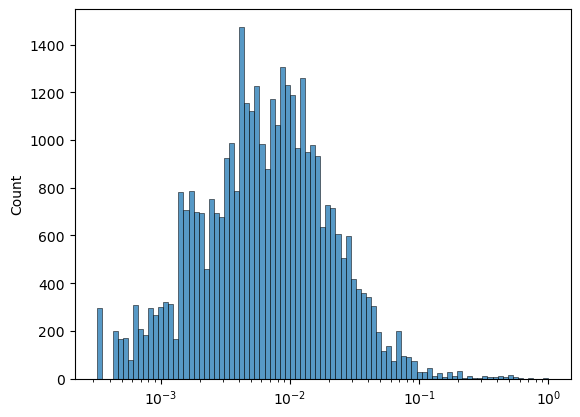

In [15]:
sns.histplot(trans_matrix.ravel(), log_scale=True)

Most of the probabilities lie around the 1% area, which is pretty rare and sparse

In [16]:
course_index = dataset.course_set.index

course_transitions = [
    (course_index[i], course_index[j], adj_matrix[i, j], trans_matrix[i, j])
    for i in range(adj_matrix.shape[0])
    for j in range(adj_matrix.shape[1])
    if adj_matrix[i, j] > 0
]

df_transitions = pd.DataFrame(course_transitions, columns=['prev_course', 'next_course', 'count', 'proba']).sort_values(by='count', ascending=False)
df_transitions.head(10)

,prev_course,next_course,count,proba
2399,neural-networks-deep-learning,deep-neural-network,1304.0,0.566218
5981,deep-neural-network,machine-learning-projects,1239.0,0.579243
1092,python,python-data,1097.0,0.352620
4827,python-data,python-network-data,1077.0,0.484698
316,technical-support-fundamentals,computer-networking,715.0,0.438920
10512,python-network-data,python-databases,694.0,0.564228
2724,what-is-datascience,open-source-tools-for-data-science,658.0,0.567731
1444,computer-networking,os-power-user,480.0,0.469667
9350,machine-learning-projects,nlp-sequence-models,465.0,0.356322
5801,open-source-tools-for-data-science,data-science-methodology,406.0,0.488568


In [17]:
df_transitions.shape

(36994, 4)

<Axes: xlabel='count', ylabel='Count'>

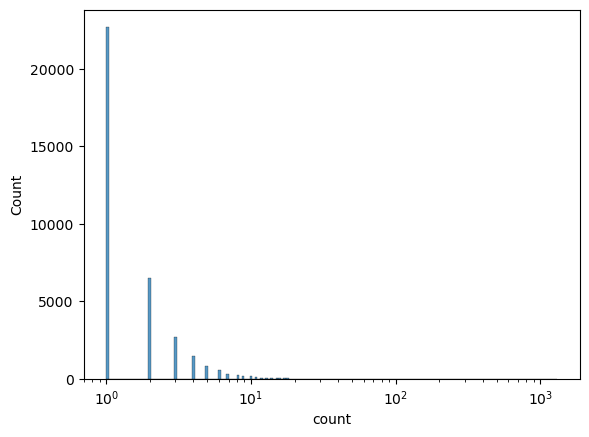

In [18]:
sns.histplot(df_transitions['count'], log_scale=True)

The long-tail is so large, even the log plot has a long tail

In [19]:
df_transitions.head(50)

,prev_course,next_course,count,proba
2399,neural-networks-deep-learning,deep-neural-network,1304.0,0.566218
5981,deep-neural-network,machine-learning-projects,1239.0,0.579243
1092,python,python-data,1097.0,0.352620
4827,python-data,python-network-data,1077.0,0.484698
316,technical-support-fundamentals,computer-networking,715.0,0.438920
10512,python-network-data,python-databases,694.0,0.564228
2724,what-is-datascience,open-source-tools-for-data-science,658.0,0.567731
1444,computer-networking,os-power-user,480.0,0.469667
9350,machine-learning-projects,nlp-sequence-models,465.0,0.356322
5801,open-source-tools-for-data-science,data-science-methodology,406.0,0.488568


In [21]:
df_probabilities = df_transitions.sort_values(by='proba', ascending=False)
df_probabilities.head(50)

,prev_course,next_course,count,proba
10230,cancer,epigenetics,1.0,1.000000
3871,excel-essentials,introduction-to-data-analytics,1.0,1.000000
8874,science-exercise,remote-team-management,1.0,1.000000
34453,nanotechnology,building-modern-python-applications-on-aws,1.0,1.000000
7379,classification-vector-spaces-in-nlp,probabilistic-models-in-nlp,30.0,0.697674
6732,project-planning,schedule-projects,188.0,0.608414
5981,deep-neural-network,machine-learning-projects,1239.0,0.579243
2724,what-is-datascience,open-source-tools-for-data-science,658.0,0.567731
2399,neural-networks-deep-learning,deep-neural-network,1304.0,0.566218
17602,fundamentals-of-reinforcement-learning,sample-based-learning-methods,39.0,0.565217


In [34]:
def sequential_recommendation_by_probability(user: str, prev_courses: set):
    _candidate_set = df_probabilities[df_probabilities['prev_course'].isin(prev_courses) & ~df_probabilities['next_course'].isin(prev_courses)]
    return _candidate_set.head(5)['next_course'].values

def sequential_recommendation_by_count(user: str, prev_courses: set):
    _candidate_set = df_transitions[df_transitions['prev_course'].isin(prev_courses) & ~df_transitions['next_course'].isin(prev_courses)]
    return _candidate_set.head(5)['next_course'].values

In [35]:
def calculate_hit_rate(X, y, recommender_func):
    hits = 0
    reqs = 0
    for (user, prev_courses), next_course in tqdm(zip(X, y), total=len(X)):
        reqs += 1
        if next_course in recommender_func(user, prev_courses):
            hits += 1
    return hits / reqs

**By count**

In [36]:
calculate_hit_rate(train_X, train_y, sequential_recommendation_by_count)

100%|██████████████████████████████████████████████████████████████████████████| 108061/108061 [03:55<00:00, 459.76it/s]


0.2636196222503956

In [37]:
calculate_hit_rate(test_X, test_y, sequential_recommendation_by_count)

100%|████████████████████████████████████████████████████████████████████████████| 35439/35439 [01:15<00:00, 470.25it/s]


0.25900843703264764

**By probability**

In [38]:
calculate_hit_rate(train_X, train_y, sequential_recommendation_by_probability)

100%|██████████████████████████████████████████████████████████████████████████| 108061/108061 [03:49<00:00, 471.41it/s]


0.18987423769907738

In [39]:
calculate_hit_rate(test_X, test_y, sequential_recommendation_by_probability)

100%|████████████████████████████████████████████████████████████████████████████| 35439/35439 [01:14<00:00, 474.04it/s]


0.1870820282739355

**Prefiltering by count, then sort by probability**

In [49]:
def sequential_recommendation_by_probability_prefilter(user: str, prev_courses: set):
    _candidate_set = df_probabilities[df_probabilities['prev_course'].isin(prev_courses) & ~df_probabilities['next_course'].isin(prev_courses)].head(20)
    return _candidate_set.sort_values(by='count', ascending=False).head(5)['next_course'].values

def sequential_recommendation_by_count_prefilter(user: str, prev_courses: set):
    _candidate_set = df_transitions[df_transitions['prev_course'].isin(prev_courses) & ~df_transitions['next_course'].isin(prev_courses)].head(20)
    return _candidate_set.sort_values(by='proba', ascending=False).head(5)['next_course'].values

In [58]:
print(f"Predicted: {sequential_recommendation_by_count_prefilter(*train_X[7])}")
print(f"Actual: {train_y[7]}")

Predicted: ['convolutional-neural-networks-tensorflow' 'python-network-data'
 'convolutional-neural-networks' 'nlp-sequence-models'
 'natural-language-processing-tensorflow']
Actual: convolutional-neural-networks-tensorflow


In [59]:
calculate_hit_rate(train_X, train_y, sequential_recommendation_by_count_prefilter)

100%|██████████████████████████████████████████████████████████████████████████| 108061/108061 [04:39<00:00, 386.64it/s]


0.23668113380405512

In [60]:
calculate_hit_rate(test_X, test_y, sequential_recommendation_by_count_prefilter)

100%|████████████████████████████████████████████████████████████████████████████| 35439/35439 [01:32<00:00, 382.42it/s]


0.23152459155168034

## Using a different dataset, predict any of the next courses

In [66]:
train_X, test_X, train_y, test_y = dataset.get_train_test_next_course_predictions()

Computing the training and test list of sequences...


131100it [00:07, 16574.16it/s]
43119it [00:02, 18118.21it/s]


In [67]:
train_X[:5]

[('By  B R s ', {'information-security-data': 5}),
 ('By  B R s ',
  {'information-security-data': 5, 'aws-fundamentals-going-cloud-native': 5}),
 ('By  B R s ',
  {'information-security-data': 5,
   'aws-fundamentals-going-cloud-native': 5,
   'python-basics': 5}),
 ('By  B S K', {'python-data': 5}),
 ('By  B S K', {'python-data': 5, 'neural-networks-deep-learning': 5})]

In [68]:
train_y[:5]

[{'aws-fundamentals-going-cloud-native': 5,
  'python-basics': 5,
  'introduction-cybersecurity-cyber-attacks': 5},
 {'python-basics': 5, 'introduction-cybersecurity-cyber-attacks': 5},
 {'introduction-cybersecurity-cyber-attacks': 5},
 {'neural-networks-deep-learning': 5,
  'deep-neural-network': 5,
  'machine-learning-projects': 4,
  'introduction-tensorflow': 5,
  'convolutional-neural-networks-tensorflow': 5,
  'tensorflow-sequences-time-series-and-prediction': 5},
 {'deep-neural-network': 5,
  'machine-learning-projects': 4,
  'introduction-tensorflow': 5,
  'convolutional-neural-networks-tensorflow': 5,
  'tensorflow-sequences-time-series-and-prediction': 5}]

In [69]:
def calculate_precision(X, y, recommender_func):
    precs = 0
    reqs = 0
    for (user, prev_courses_dict), next_courses_dict in tqdm(zip(X, y), total=len(X)):
        reqs += 1
        prev_courses = set(prev_courses_dict.keys())
        next_courses = set(next_courses_dict.keys())
        pred_courses = set(recommender_func(user, prev_courses))
        precs += (len(pred_courses & next_courses) / len(pred_courses))
    return precs / reqs

In [70]:
calculate_precision(train_X, train_y, sequential_recommendation_by_count)

100%|██████████████████████████████████████████████████████████████████████████| 108061/108061 [04:21<00:00, 413.97it/s]


0.14535231643860141

In [71]:
calculate_precision(test_X, test_y, sequential_recommendation_by_count)

100%|████████████████████████████████████████████████████████████████████████████| 35439/35439 [01:21<00:00, 436.83it/s]


0.1439360591438593

In [72]:
calculate_precision(train_X, train_y, sequential_recommendation_by_count_prefilter)

100%|██████████████████████████████████████████████████████████████████████████| 108061/108061 [05:29<00:00, 328.40it/s]


0.11675581384590335

In [73]:
calculate_precision(test_X, test_y, sequential_recommendation_by_count_prefilter)

100%|████████████████████████████████████████████████████████████████████████████| 35439/35439 [01:39<00:00, 355.41it/s]


0.11380164978318709